# O Mundo Assombrado Pelos Demônios - Carl Sagan: 
## Análise de similaridade de reviews 
Os apaixonados por literatura, assim como eu, já tiveram momentos em que lendo as páginas de um livro instigante se sentiram preenchidos com uma sensação de maravilhamento e de descoberta, que abriram os olhos para uma nova percepção de mundo. Após esse momento há a impressão de que os horizontes do nosso mundo, e da realidade, se expandiu, e nos proporcionou um novo entendimento e maior compreensão, seja em um tema específico ou sobre a nossa vida em geral.<br>

Tive muitos momentos assim, e com muitos livros diferentes, porém, me lembro que durante e após a leitura de "O Mundo Assombrado pelos Demônios", de Carl Sagan, isso aconteceu de maneira tão intensa que se tornou um dos meus livros favoritos, e o autor um dos que mais admiro, se tornando extremamente especial para mim.<br>

Durante meses queria falar e discutir sobre as ideias que absorvi. Ler os livros de Carl Sagan, e tantos outros autores,  me deixaram maravilhado com o fato de que a ciência, o método científico, o pensamento crítico e suas aplicações trazem benefícios enormes para o ser humano e a sociedade. Isso me tornou cada vez mais curioso, fortaleceu meu senso crítico, e ajudou a moldar uma visão de mundo que julgo ser extremamente saudável, que é a de ser um indivíduo cético, que faz uso das ferramentas da ciência para guiar minhas escolhas, ideias e vida.<br>

Depois de quase 20 anos da minha primeira leitura do livro, e estudando ciência de dados, fiquei curioso para saber:

1. Quais são as impressões gerais que as pessoas tem, do autor e do livro, após a leitura?
2. Será que o livro tem/teve o mesmo impacto em outras pessoas assim como teve sobre mim?

Para a análise será necessário aplica processamento de linguagem natural (**NLP**), e para este projeto escolhi a biblioteca **spaCy**.

# Roteiro

1. Coleta de dados: coleta realizada com reviews do livro, por webscraping, no site amazon.com.br
2. Limpeza e preparação de dados: remoção de stopwords, pontuação, numeros e conversão para caixa baixa
3. Gerando N-GRAMS e Bag of Words (BOW): gerar UNI, BI e TRI-GRAMS e excluir termos que não agregam a análise
4. Representação: WORDCLOUD e gráfico de frequencia de NGRAMS
5. Análise de similaridade: aplicação de modelo para calcular similaridade (cosine similarity) entre meus reviews e reviews coletados
6. Avaliando resultados: representação com WORDCLOUD e frequencia de NGRAMS e reviews com maior similaridade aos meus reviews
7. Conclusão

In [2]:
import spacy
import warnings
import pandas as pd
import seaborn as sns
import pt_core_news_lg
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from spacy.lang.pt.stop_words import STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer

plt.style.use('ggplot')
warnings.filterwarnings('ignore')

# 1.Coleta de dados
- Já executada (arquivo em pasta)

In [3]:
# Carregando dados
df = pd.read_csv('data/mundo_assombrado_reviews.csv', index_col=False)

# Averiguando info e nulos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 724 entries, 0 to 723
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   reviews  716 non-null    object
dtypes: object(1)
memory usage: 5.8+ KB


In [4]:
# Excluindo dados nulos
df.dropna(inplace=True)

# 2.Limpeza e preparação de dados
Instanciamos o "pt_core_news_lg" da biblioteca spaCy, que é um modelo pré-treinado para processamento de textos na língua portuguesa.<br>
Este em especifico é um modelo com um grande corpus de textos na língua portuguesa, ou seja, um conjunto de dados numeroso (700k palavras unicas e 2.7M vetores de palavras) que permite ao modelo captar a riqueza e diversidade da língua.<br>
Com modelos desse tipo podemos executar diversas tarefas como:
- Tokenização: transformar partes do texto, palavras unicas ou conjunto de palavras (N-GRAMS), em unidades conhecidas como tokens
- Part of speech (POS): reconhecimento de classes gramaticais 
- Named entity recognition (NER) - reconhecimento de entidades, como pessoas, locais, instituições

In [5]:
# Instanciando spacy
nlp = spacy.load('pt_core_news_lg')

In [6]:
# Definindo função para limpeza de texto
def limpar_texto(texto):
    # Converte para caixa baixa
    texto = texto.lower()
    
    # Tokenização
    doc = nlp(texto)
    
    # Exclui STOPWORDS, pontuação e números
    tokens = [token.text for token in doc if not token.is_stop and not token.is_punct and not token.like_num]
    
    # Agrupando review
    texto_limpo = " ".join(tokens)
    
    return texto_limpo

In [7]:
# Criação lista com reviews limpos
reviews_limpos = df['reviews'].apply(limpar_texto)

# Criação de coluna no DF com reviews limpos
df['reviews_limpos'] = df['reviews'].apply(limpar_texto)

Criaremos essa função pois após tratamento inicial dos textos criaremos um dataframe com os tokens estipulados e a identificação do review(linha do dataframe) em que esse token aparece. Porém, não há uma função integrada na biblioteca para atribuir rotulos dos tokens às colunas que eles pertencem.

In [8]:
# Função para extrair rotulos de tokens e atribuir a colunas do dataframe
def nome_colunas(tokenizer, data_frame):
    # Extrai rotulos dos tokens
    vocabulario = {v: k for k, v in tokenizer.vocabulary_.items()}
    
    # Atribui rotulos dos tokens as colunas apropriadas
    data_frame.columns = data_frame.columns.map(vocabulario)
    
    return data_frame

# 3.Gerando N-GRAMS e Bag of Words (BOW)
Podemos analisar o texto com várias técnicas, e uma delas é o bag of words (BOW) que consiste em representar texto em forma de vetores. Para isso temos que transformar os textos em unidades, que podem variar de uma a "N" palavras por token.<br>
Faremos a análise com UNI, BI e TRI-GRAMS.<br>
Após a criação dos N-GRAMS usaremos bag of words (BOW) para representar textos como vetores, com ajuda do CountVectorizer da biblioteca Scikit-Learn, que cria uma matriz de contagem de tokens.


## UNI-GRAM

In [9]:
# Instanciando CountVectorizer
tokenizer_unigram = CountVectorizer(ngram_range=(1,1))

# Fit e transform dos reviews limpos, cria uma matriz esparsa
bow_unigram = tokenizer_unigram.fit_transform(df['reviews_limpos'])

# Criação do DF
bow_unigram_df = pd.DataFrame(bow_unigram.todense())

In [10]:
# Aplicando função
nome_colunas(tokenizer_unigram, bow_unigram_df)

,2019,2022,480,abaixo,abala,abandonado,abduzidos,abduzí,abdução,abduções,...,ótimas,ótimo,ótimooo,ótimos,ônibus,últimos,única,único,úteis,útil
0,0,0,0,0,0,0,2,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
711,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
712,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
713,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
714,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
# Palavras sem ou com pouco valor, selecionadas para exclusão
excluir_cols_unigram = ['livro', 'sagan', 'carl', 'carlr', 'chegou', 'pra', 'edição', 
                        'capa', 'bolso','hoje', 'mostra', 'escrito', 'anos', 'coisas',
                        'entrega', 'simples', 'assuntos', 'leitor', 'principalmente',
                        'vale', 'produto', 'extremamente','questões', 'visões', 'muitas',
                        'há', 'pena', 'dias', 'livros', 'mente', 'dia', 'pessoa', 'seja', 
                        'sendo', 'se',' leitura', 'ler', 'autor', 'pessoas', 'li', 'trata',
                        'maneira', 'páginas', 'simplesmente', 'tamanho', 'capítulos',
                        'sido', 'veio',' escrita']


# Excluindo palavras das colunas do DF
for item in bow_unigram_df.columns:
    if item in excluir_cols_unigram:
        bow_unigram_df.drop(columns=[item], inplace=True)

In [12]:
# Verificando 50 termos mais frequentes
bow_unigram_df.sum().sort_values(ascending=False).head(50)

ciência           192
leitura           183
mundo              94
científico         78
excelente          68
obra               59
ótimo              58
recomendo          56
pensamento         53
vida               53
deveria            51
ceticismo          49
melhor             46
atual              42
conhecimento       41
conteúdo           40
sociedade          39
obrigatória        37
método             34
incrível           31
demônios           31
científica         31
qualidade          29
humanidade         29
crítico            29
pseudociência      28
crenças            28
importância        27
maravilhoso        25
divulgação         25
perfeito           25
gostei             23
pensar             22
linguagem          22
visão              22
fácil              22
escolas            21
tempos             20
entender           20
pseudociências     19
interessante       19
questionar         18
fatos              18
fantástico         18
super              18
verdade   

## BI-GRAM

In [13]:
# Instanciando CountVectorizer
tokenizer_bigram = CountVectorizer(ngram_range = (2,2))

# Fit e transform dos reviews limpos, cria uma matriz esparsa
bow_bigram = tokenizer_bigram.fit_transform(df['reviews_limpos'])

# Criação do DF
bow_bigram_df = pd.DataFrame(bow_bigram.todense())

In [14]:
# Aplicando função
nome_colunas(tokenizer_bigram, bow_bigram_df)

,2019 2022,2022 pandemia,abaixo infelizmente,abala fundamento,abandonado investimentos,abduzidos iludidos,abduzidos tivessem,abduzí los,abdução alienígena,abdução et,...,única permitindo,único arrependimento,único capítulo,único defeito,úteis verídicas,útil desenvolvimento,útil entendimento,útil física,útil principalmente,útil sociedade
0,0,0,0,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
711,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
712,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
713,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
714,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
# Palavras sem ou com pouco valor, selecionadas para exclusão
excluir_cols_bigram = ['carl sagan', 'ler livro', 'livro chegou', 'livro leitura',
                       'livro li', 'livro carl', 'entrega rápida',' leiitura livro',
                       'edição bolso', 'livros li', 'livro veio','letras pequenas',
                       'sagan fala', 'chegou prazo', 'livro escrito',' conteúdo livro',
                       'ciência carl', 'sagan mostra', 'chegou perfeito', 'sido escrito',
                       'sagan incrível', 'livro bolso', 'super rápido', 'sagan livro',
                       'há anos', 'chegou embalado', 'livro traz', 'livro tamanho',
                       'leitura livro', 'play video']


# Excluindo palavras das colunas do DF
for item in bow_bigram_df.columns:
    if item in excluir_cols_bigram:
        bow_bigram_df.drop(columns=[item], inplace=True)

In [16]:
# Verificando 50 termos mais frequentes
bow_bigram_df.sum().sort_values(ascending=False).head(50)

leitura obrigatória         33
método científico           28
ótimo livro                 27
pensamento crítico          19
excelente livro             16
divulgação científica       16
deveria leitura             15
melhor livro                15
livro maravilhoso           14
livro excelente             14
livro deveria               12
melhores livros             12
vale pena                   11
mundo assombrado            10
livro incrível              10
assombrado demônios         10
mundo deveria                9
pensamento científico        8
analfabetismo científico     8
importância ciência          8
excelente leitura            8
recomendo leitura            8
pensamento cético            8
dias atuais                  7
senso crítico                7
deveriam ler                 7
linguagem simples            7
conteúdo livro               7
gostei livro                 7
livro ótimo                  7
conhecimento científico      7
livro fundamental            7
obrigató

## TRI-GRAM

In [17]:
# Instanciando CountVectorizer
tokenizer_trigram = CountVectorizer(ngram_range=(3,3))

# Fit e transform dos reviews limpos, cria uma matriz esparsa
bow_trigram = tokenizer_trigram.fit_transform(df['reviews_limpos'])

# Criando DF
bow_trigram_df = pd.DataFrame(bow_trigram.todense())

In [18]:
# Aplicando função
nome_colunas(tokenizer_trigram, bow_trigram_df)

,2019 2022 pandemia,2022 pandemia abala,abaixo infelizmente filtro,abala fundamento sociedade,abandonado investimentos ciência,abduzidos iludidos concluiu,abduzidos tivessem feito,abduzí los espaçonaves,abdução alienígena pequenas,abdução et apesar,...,única luz mundo,única permitindo leitor,único arrependimento tê,único capítulo sagan,único defeito apontaria,útil desenvolvimento pensamento,útil entendimento funciona,útil física biologia,útil principalmente sociedade,útil sociedade fazendo
0,0,0,0,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
711,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
712,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
713,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
714,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
# Palavras sem ou com pouco valor, selecionadas para exclusão
excluir_cols_trigram = ['livro carl sagan', 'livro deveria leitura', 'livro chegou perfeito',
                        'li carl sagan', 'carl sagan fala', 'livros carl sagan', 'livro li vida',
                        'deveria lido pessoas', 'carl sagan maiores', 'ler carl sagan',
                        'carl sagan mostra', 'carl sagan escreve', 'chegou ótimas condições',
                        'chegou super rápido', 'livro chegou super', 'tenha sido escrito',
                        'livro aborda temas', 'carl sagan apresenta', 'livro excelente livro',
                        'carl sagan definitivamente', 'produto chegou ótimo', 'again and again',
                        'chegou embalado super', 'chegou esperado perfeito', 'leitura livro apresenta',
                        'trata edição bolso', 'embalado super rápido', 'livro li carl', 
                        'chegou perfeito prazo', 'sagan escreveu livro', 'livro há anos',
                        'humano dividido capítulos']


# Excluindo palavras das colunas do DF
for item in bow_trigram_df.columns:
    if item in excluir_cols_trigram:
        bow_trigram_df.drop(columns=[item], inplace=True)

In [20]:
# Verificando 50 termos mais frequentes
bow_trigram_df.sum().sort_values(ascending=False).head(50)

deveria leitura obrigatória         15
melhor livro li                      9
melhores livros li                   8
mundo assombrado demônios            8
leitura obrigatória escolas          7
ciência carl sagan                   6
mundo deveria ler                    6
carl sagan incrível                  5
divulgação científica livro          4
carl sagan gênio                     4
funciona método científico           4
carl sagan dispensa                  4
livro divulgação científica          4
obra carl sagan                      4
leitura obrigatória ensino           3
livro mudou vida                     3
sagan maiores divulgadores           3
livro leitura obrigatória            3
vale pena lido                       3
maiores divulgadores científicos     3
obrigatória ensino médio             3
uso método científico                2
hoje excelente leitura               2
trata questões políticas             2
questionar informações recebemos     2
livro abre mente         

# 4.Representação
## Definindo funções

### WORDCLOUD

In [21]:
# Criando função WORDCLOUD
def word_cloud(df, max_termos=50, largura = 1200, altura = 800, alinhamento = 0.9, fonte_min = 4, fonte_max = None):
    # Converter dataframe para dicionário
    freq_dict = dict(zip(df.termo, df.frequencia))

    # Definir parâmetros 
    wordcloud = WordCloud(width = largura, height = altura, max_words = max_termos, 
                          prefer_horizontal= alinhamento, max_font_size = fonte_max,
                          min_font_size = fonte_min, collocations=False).generate_from_frequencies(freq_dict)

    # Definir título, tamanho de fonte e gráfico e detalhes
    plt.figure(figsize = (10, 5), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()

### GRÁFICO DE FREQUÊNCIA (BARRAS)

In [22]:
# Criando função gráfico de frequência de N-GRAMS
def gram_freq(data_frame, n_gram = None):
    # Definir tamanho do gráfico
    plt.figure(figsize=(9,5))
    
    # Definir parâmetros
    sns.barplot(data_frame[:25], x = 'frequencia', y = 'termo', color = 'blue')
    
    # Definir título, tamanho de fonte e gráfico e detalhes
    plt.title(f'25 {n_gram.upper()}-GRAMS mais frequentes', fontsize = 14)
    plt.xlabel('')
    plt.ylabel('')
    plt.yticks(fontsize = 9)
    plt.show()

## Criando dataframes

In [23]:
# UNIGRAM
bow_unigram_df = bow_unigram_df.sum().sort_values(ascending=False).head(50)
bow_unigram_df = bow_unigram_df.to_frame().reset_index()
bow_unigram_df.columns = ['termo', 'frequencia']

# BIGRAM
bow_bigram_df = bow_bigram_df.sum().sort_values(ascending=False).head(50)
bow_bigram_df = bow_bigram_df.to_frame().reset_index()
bow_bigram_df.columns = ['termo', 'frequencia']

# TRIGRAM
bow_trigram_df = bow_trigram_df.sum().sort_values(ascending=False).head(50)
bow_trigram_df = bow_trigram_df.to_frame().reset_index()
bow_trigram_df.columns = ['termo', 'frequencia']

# 5.Análise de similaridade - Cosine Similarity

In [36]:
# Definição da função com modelo de análise de similaridade
def analise_similaridade(processador, seu_review, reviews, limiar_similaridade = 0.75):
    # Convertendo review em caixa baixa
    seu_review = seu_review.lower()
    
    # Transformando meu review em doc    
    seu_review_doc = processador(seu_review)

    # Aplicando pipeline nos reviews limpos
    reviews_docs = list(processador.pipe(reviews))

    # Calculando score de similaridade entre meu review e todos os reviews
    score_similaridade = []

    for doc in reviews_docs:
        score_similaridade.append(seu_review_doc.similarity(doc))
        
    # Atribuindo score aos reviews em coluna no dataframe
    df['score_similaridade'] = score_similaridade
    
    # Ordenando reviews por score de similaridade em ordem descendente
    top_reviews = df[['reviews', 'score_similaridade']].sort_values(by=['score_similaridade'])
    
    # Estipulando limiar de score de similaridade
    top_reviews = top_reviews[top_reviews['score_similaridade'] >= limiar_similaridade]
    
    # Identificar número de reviews pelas faixas de similaridade
    mais_90 = top_reviews[top_reviews['score_similaridade'] > 0.9]
    
    entre_80_90 = top_reviews[(top_reviews['score_similaridade'] > 0.8) & (top_reviews['score_similaridade'] <= 0.9)]
    
    entre_70_80 = top_reviews[(top_reviews['score_similaridade'] > 0.7) & (top_reviews['score_similaridade'] <= 0.8)]
    
    entre_60_70 = top_reviews[(top_reviews['score_similaridade'] > 0.6) & (top_reviews['score_similaridade'] <= 0.7)]
    
    print('='*66)
    print('\033[1m' + f'  {top_reviews.shape[0]} pessoas ({(top_reviews.shape[0]/df.shape[0])*100:.2f}%) que leram o livro tem opinião similar!' + '\033[0m')
    print('='*66)
    print('\033[1m' + f'  > 90% de similaridade: {mais_90.shape[0]} reviews ' + '\033[0m')
    print('='*66)
    print('\033[1m' + f'  80-90% de similaridade: {entre_80_90.shape[0]} reviews' + '\033[0m')
    print('='*66)
    print('\033[1m' + f'  70-80% de similaridade: {entre_70_80.shape[0]} reviews' + '\033[0m')
    print('='*66)
    print('\033[1m' + f'  60-70% de similaridade: {entre_60_70.shape[0]} reviews' + '\033[0m')
    print('='*66)
     
    return top_reviews.sort_values(by='score_similaridade', ascending = False).head(7)

# 6.Avaliando resultados
## Representação com WORDCLOUD e frequencia de NGRAMS

### UNI-GRAM

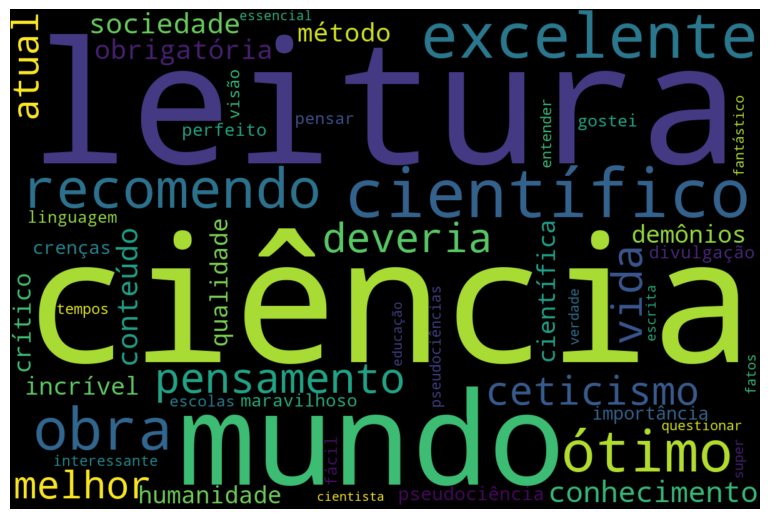

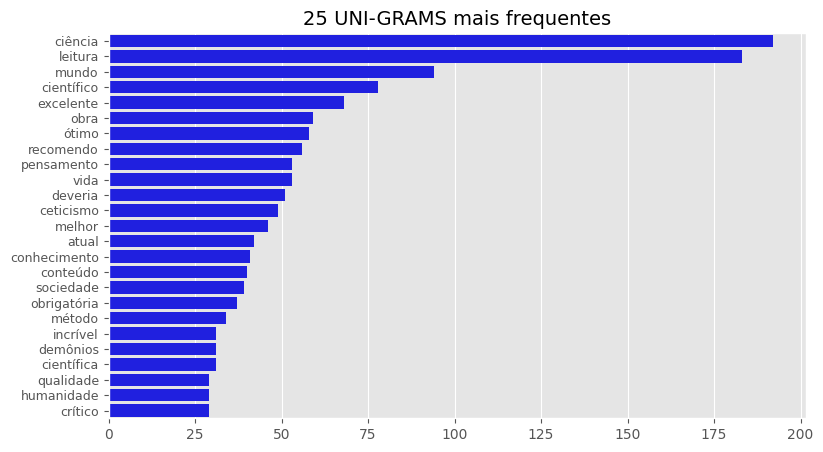

In [25]:
word_cloud(bow_unigram_df, alinhamento = .5)

gram_freq(bow_unigram_df, n_gram='UNI')

Com UNI-GRAMS podemos ver que palavras únicas referenciando a **CIÊNCIA** e seus atributos ("ciência", "científico", "ceticismo", "conhecimento", "crítico", "método") e elogios ao livro ("excelente", "ótimo", "bom", "atual", "incrível").

### BI-GRAM

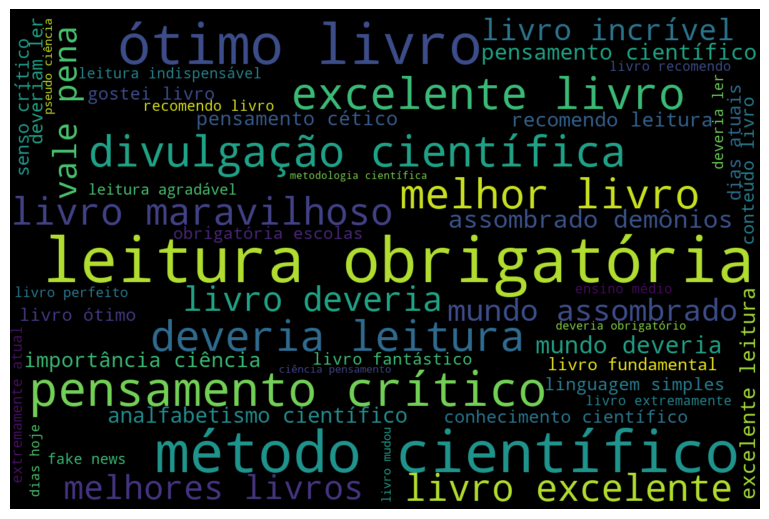

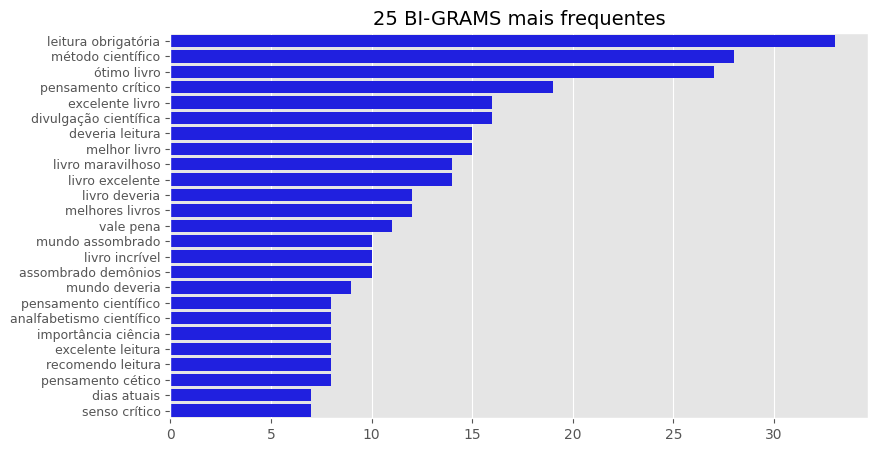

In [26]:
word_cloud(bow_bigram_df, alinhamento = .5)

gram_freq(bow_bigram_df, n_gram = 'BI')

Com BI-GRAMS começamos a perceber alguns contextos também relacionados a **CIÊNCIA** ("método científico", "pensamento crítico", "divulgação científica", "pensamento científico", "analfabetismo científico", "pensamento cético", "senso crítico") e elogios ao livro e o valor que ele pode ter para as pessoas ("excelente livro", "ótimo livro", "deveria leitura", "excelente leitura", "recomendo leitura", "vale pena").

### TRI-GRAM

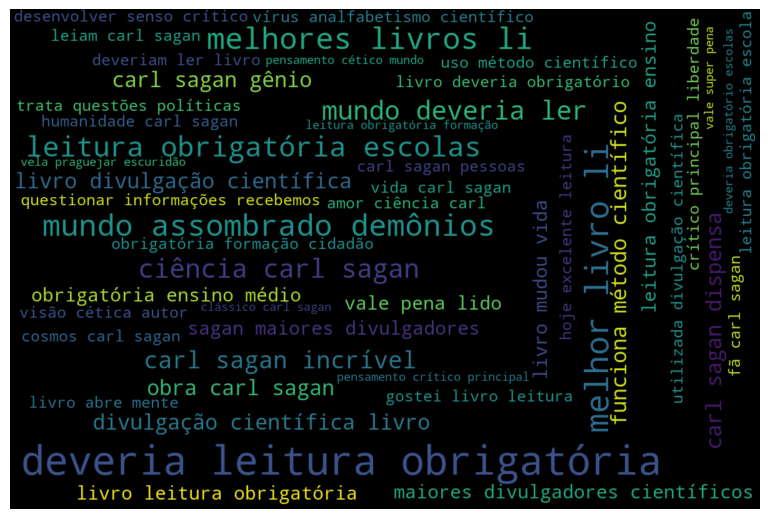

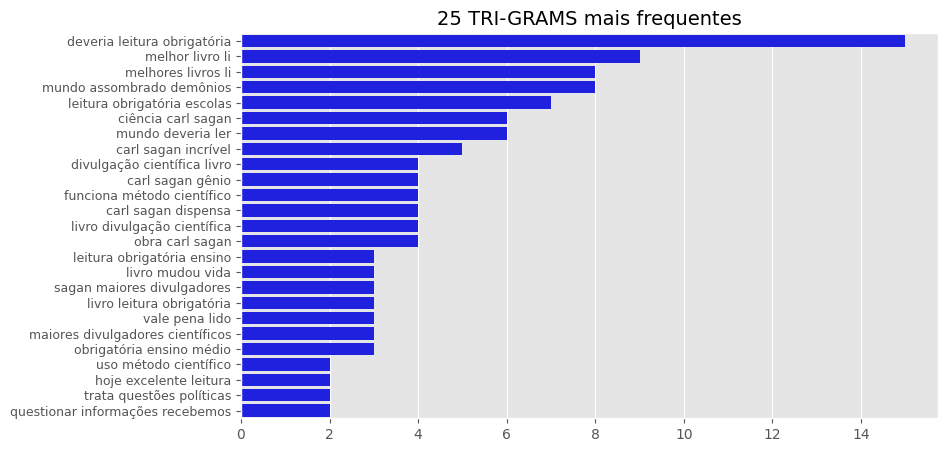

In [27]:
word_cloud(bow_trigram_df, alinhamento = .7)

gram_freq(bow_trigram_df, n_gram = 'TRi')

Por fim, com TRI-GRAMS vemos contextos aparecerem mais evidentemente, porém em menor número, também relacionados a **CIÊNCIA** ("divulgação científica livro", "funciona método científico", "uso método científico", "questionar informações recebemos"), elogios e o valor social do livro ("deveria leitura obrigatória", "melhor livro li", "melhores livros li", "leitura obrigatória escolas", "mundo deveria ler", "leitura obrigatória ensino", "livro mudou vida", "livro leitura obrigatória", "obrigatória ensino médio") e também elogios ao autor ("carl sagan incrível", "carl sagan gênio", "carl sagan dispensa", "sagan maiores divulgadores", "maiores divulgadores científicos").

## Similaridade de Reviews
### Classificação dos reviews
Dados coletados da pagina de reviews do livro na Amazon

In [28]:
# Definindo gráfico de classificação de reviews
avaliacao_df = pd.DataFrame(data = {"reviews":['Total', 'Positivos', 'Positivos 5 estrela'],
                                    "quantidade":[726, 672, 605]})

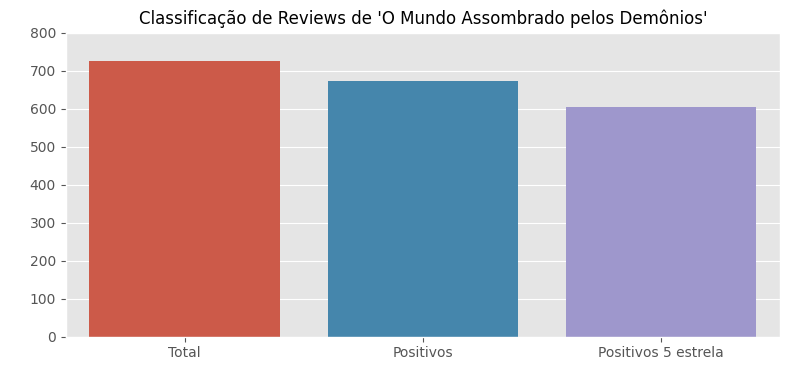

In [29]:
# Gráfico de barras dos reviews e suas classificações
plt.figure(figsize = (8,4))

sns.barplot(avaliacao_df, x = 'reviews', y = 'quantidade')
# Definir título
plt.title("Classificação de Reviews de 'O Mundo Assombrado pelos Demônios'", fontsize=12)
# Retira rótulos dos eixos
plt.xlabel(" ")
plt.ylabel(" ")
# Estabelece limite do eixo y
plt.ylim([0,800])

plt.tight_layout()

Após ler o livro fiquei com inúmeras impressões positivas, assim como os leitores que deram seu review na Amazon. De 726 reviews, 672 foram positivos (92,56%) e 605 foram classificados com 5 estrelas (83,33%), uma ótima taxa de aceitação (números coletados até o momento da extração dos dados).<br>
Além de pensar em como achei o livro incrível fiquei pensando em como ele é essencial para todas as pessoas, todas as pessoas poderiam se beneficiar, com o desenvolvimento de um senso crítico, e aplicação de conceitos básicos do método científico proporcionados pelas informações que Sagan consegue transmitir com tanta facilidade e de maneira acessível.<br>
Selecionei 5 reviews que eu daria no site para descrever minha experiencia com a leitura do livro.

### Meu Reviews

#### #1 "Necessário para construir meu senso crítico"

In [37]:
analise_similaridade(nlp, 'Necessário para construir senso crítico', reviews_limpos, limiar_similaridade = .6)

  276 pessoas (38.55%) que leram o livro tem opinião similar!
  > 90% de similaridade: 0 reviews 
  80-90% de similaridade: 5 reviews
  70-80% de similaridade: 102 reviews
  60-70% de similaridade: 169 reviews


,reviews,score_similaridade
462,Leitura obrigatória para quem deseja aprimorar...,0.874485
67,Nos ensina como pensar de forma crítica e a te...,0.831860
91,Um livro mais que perfeito para o atual moment...,0.828674
636,Ajuda a desenvolver um pouco do ceticismo nece...,0.824773
120,Excelente serviço de entrega e o produto veio ...,0.820536
418,Leitura obrigatória para todos os que desejam ...,0.798958
699,Este deveria ser um livro obrigatório nas esco...,0.795188


#### #2 "Livro incrível, mudou minha maneira de pensar e ver o mundo"

In [38]:
analise_similaridade(nlp, 'Livro incrível, mudou minha maneira de pensar e ver o mundo', reviews_limpos, limiar_similaridade = .6)

  303 pessoas (42.32%) que leram o livro tem opinião similar!
  > 90% de similaridade: 0 reviews 
  80-90% de similaridade: 0 reviews
  70-80% de similaridade: 42 reviews
  60-70% de similaridade: 261 reviews


,reviews,score_similaridade
225,Carl Sagan é um extraterrestre - brincadeira. ...,0.791055
186,É redundante e até clichê dizer que Sagan é o ...,0.772240
283,Esse foi um dos livros mais marcantes de minha...,0.766294
83,"Minha expectativa para este livro era enorme, ...",0.760327
128,Meu primeiro contato com a Sagan foi uma exper...,0.757465
685,"Depois de ter assistido ao vídeo ""o pálido pon...",0.757445
566,O livro abre sua mente em relação a diversos a...,0.755544


#### #3 "Melhor livro que li"

In [39]:
analise_similaridade(nlp, 'Melhor livro que li', reviews_limpos, limiar_similaridade = .6)

  146 pessoas (20.39%) que leram o livro tem opinião similar!
  > 90% de similaridade: 2 reviews 
  80-90% de similaridade: 7 reviews
  70-80% de similaridade: 25 reviews
  60-70% de similaridade: 112 reviews


,reviews,score_similaridade
672,Melhor livro que li até hoje!,0.923907
158,"Melhor livro que já li, aprendi dms!",0.906800
303,"Melhor livro q já li.\nCarl Sagan, como sempre...",0.891831
260,"Ainda não terminei de ler, mas até onde li, o ...",0.862936
57,"Um dos melhores livros que já li, muito esclar...",0.858979
145,Adoro o Sagan e esse livro não podia faltar na...,0.858758
272,Um dos melhores livros que já li.....recomendo...,0.843151


#### #4 "Pelo livro podemos ver como a ciência é importante para a humanidade"

In [40]:
analise_similaridade(nlp, 'Pelo livro podemos ver como a ciência é importante para a humanidade', reviews_limpos, limiar_similaridade = .6)

  264 pessoas (36.87%) que leram o livro tem opinião similar!
  > 90% de similaridade: 0 reviews 
  80-90% de similaridade: 0 reviews
  70-80% de similaridade: 45 reviews
  60-70% de similaridade: 219 reviews


,reviews,score_similaridade
708,"Essa é uma obra que, se fosse lida por todos o...",0.776147
636,Ajuda a desenvolver um pouco do ceticismo nece...,0.758197
186,É redundante e até clichê dizer que Sagan é o ...,0.756456
38,Trata sobre a constante necessidade do homem q...,0.752334
67,Nos ensina como pensar de forma crítica e a te...,0.743597
459,Uma excelente explicação sobre o funcionamento...,0.742714
571,Esse livro me causa um grande angústia ao demo...,0.739939


#### 5# "Sagan torna a ciência acessível e interessante"

In [41]:
analise_similaridade(nlp, 'Sagan torna a ciência acessível e interessante', reviews_limpos, limiar_similaridade = .6)

  242 pessoas (33.80%) que leram o livro tem opinião similar!
  > 90% de similaridade: 0 reviews 
  80-90% de similaridade: 0 reviews
  70-80% de similaridade: 69 reviews
  60-70% de similaridade: 173 reviews


,reviews,score_similaridade
322,Sagan mantém a postura de discutir ciência com...,0.778556
52,Eu sempre fui um aficionado por histórias sobr...,0.771576
459,Uma excelente explicação sobre o funcionamento...,0.770430
102,O livro desmistifica a ciência em suas várias ...,0.768997
32,"Toda boa leitura traz algo novo, enriquecedor ...",0.768863
502,É incrível como lá atrás Carl Sagan já previa ...,0.766750
1,Eu achei uma leitura fascinante e desafiadora....,0.764776


#### 6# "Livro maravilhoso"

In [42]:
analise_similaridade(nlp, 'livro maravilhoso', reviews_limpos, limiar_similaridade = .6)

  169 pessoas (23.60%) que leram o livro tem opinião similar!
  > 90% de similaridade: 23 reviews 
  80-90% de similaridade: 16 reviews
  70-80% de similaridade: 43 reviews
  60-70% de similaridade: 87 reviews


,reviews,score_similaridade
470,Livro maravilhoso!!,1.000000
323,Esse livro é magnífico!,0.964320
477,Livro incrível,0.961951
536,Livro muito bom,0.935950
554,Livro muito bom.,0.935950
700,Um bom livro.,0.935950
486,Livro maravilhoso. Nenhuma avaria em qualquer ...,0.930554


# 7.Conclusão

A análise, de certa forma, conseguiu responder às minhas perguntas.

**1.Quais são as impressões gerais que as pessoas tem, do autor e do livro, após a leitura?**<br>
Podemos observar que o maravilhamento com o método científico, produção de ciência e aplicação dela em nossas vidas, assim como elogios ao autor e o impacto do livro na vida dos leitores apareceu em número considerável nos reviews coletados. UNI-GRAMS, por serem compostos de apenas uma palavra por token, aparecem mais vezes, e a frequencia diminui com o aumento do tamanho dos tokens (no caso dos BI e TRI-GRAMS), porém observando o contexto e frases geradas podemos observar que frases diferentes tem significado similares. Isso poderia ser aprimorado com uma análise e limpeza mais minuciosa.

**2.Será que o livro tem/teve o mesmo impacto em outras pessoas assim como teve sobre mim?**<br>
Apesar de o modelo de análise de similaridade (Cosine Similarity) ser um modelo base (simples) ele conseguiu captar o teor e contexto dos reviews e das minhas impressões, e com os parâmetros estipulados conseguimos observar que uma parcela relevante dos leitores tem opiniões similares. Esses resultados me levam a imaginar que o livro realmente tem um efeito extremamente positivo de maravilhamento, estímulo de uma maneira de ver o mundo de forma mais cética, crítica e humilde e aguçando a curiosidade do leitor, provavelmente levando o leitor a um caminho sem volta que é a literatura científica (sou muito suspeito para falar).<br>

É importante observar que as técnicas e parâmetros utilizados para tratar os dados e construir o modelo podem ser modificados para aprimorar o modelo, para que possa captar de forma mais eficiente as nuânces e riquezas dos discursos, isso pode ser feito com uso de outras técnicas para tratamento de dados e o aprimoramento do modelo de análise de similaridade, também alterando parâmetros, como o limiar de similaridade (estipulado como 0.6), e utilização de outras bibliotecas (como NLTK).<br>

Podemos notar que apesar de o modelo ter conseguido identificar discursos semelhantes às minhas impressões o score de similaridade em muitos casos se manteve abaixo dos 80%, e quanto menor a frase a ser comparada (meu review) melhor o modelo performa. Assim se quisessemos um modelo com uma performance mais apurada precisariamos trabalhar mais na limpeza e construção de um modelo mais eficiente, mas se tratando de um modelo inicial obtivemos bons resultados.<br>

Estamos no caminho certo!